In [346]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

In [347]:
import torch 
import torch.nn as nn
from torch.autograd import Variable 

In [348]:
from sklearn.model_selection import train_test_split

In [349]:
from sklearn.metrics import r2_score

In [350]:
df026_dag = pd.read_csv('df026_perdag', index_col=0)

In [351]:
def df_to_X_y(df, window_size=72):
    X = []
    y = []
    for i in range(len(df) - window_size):
        row = [[k] for k in df[i:i+window_size]]
        X.append(row)
        label = df[i+window_size]
        y.append([label])
    return np.array(X), np.array(y)

In [352]:
class LSTM1(nn.Module):
    def __init__(self, classes, features, hidden_size, layers):
        super(LSTM1, self).__init__()
        self.classes = classes
        self.features = features
        self.hidden_size = hidden_size
        self.layers = layers
        
        self.lstm = nn.LSTM(input_size=features, hidden_size=hidden_size, num_layers=layers, batch_first=True)
        self.fc = nn.Linear(128, classes)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.relu = nn.ReLU()
    def forward(self, x):
        h0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_size)) 
        c0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_size)) 
  
        out, (hn, cn) = self.lstm(x, (h0, c0)) 
        hn = hn.view(-1, self.hidden_size) 
        output = self.relu(hn)
        output = self.fc1(output) 
        output = self.relu(output) 
        output = self.fc(output) 
        return output

In [353]:
df026_dag['stat'] = df026_dag['perdag_verbruik'].diff().fillna(0)
df026_dag_stat = df026_dag['stat']

In [354]:
df026_dag

,solar_total_energy_out,solar_perdag_total_energy_out,total_energy_in,total_energy_out,perdag_total_energy_out,perdag_total_energy_in,verbruik,perdag_verbruik,stat
2019-01-01,174.98,2.70,901.5220,98.236,1.893,8.2325,978.2660,9.0395,0.0000
2019-01-02,177.68,2.55,909.7545,100.129,1.640,8.7330,987.3055,9.6430,0.6035
2019-01-03,180.23,5.03,918.4875,101.769,3.124,11.1760,996.9485,13.0820,3.4390
2019-01-04,185.26,0.63,929.6635,104.893,0.002,12.5180,1010.0305,13.1460,0.0640
2019-01-05,185.89,0.84,942.1815,104.895,0.087,11.8340,1023.1765,12.5870,-0.5590
...,...,...,...,...,...,...,...,...,...
2019-12-28,7579.81,5.01,2594.4730,6774.460,1.897,11.9190,3399.8230,15.0320,0.9190
2019-12-29,7584.82,3.82,2606.3920,6776.357,0.323,13.7930,3414.8550,17.2900,2.2580
2019-12-30,7588.64,7.63,2620.1850,6776.680,3.350,7.4460,3432.1450,11.7260,-5.5640
2019-12-31,7596.27,NaN,2627.6310,6780.030,3.524,7.5380,3443.8710,NaN,0.0000


In [355]:
data = df026_dag_stat[:-2]

In [356]:
X, y = df_to_X_y(data, 7)
X[1], y[1]

(array([[ 0.6035],
        [ 3.439 ],
        [ 0.064 ],
        [-0.559 ],
        [-2.575 ],
        [ 0.992 ],
        [-1.7605]]),
 array([3.7315]))

In [357]:
X.shape, y.shape

((357, 7, 1), (357, 1))

In [358]:
X_train, y_train = X[:300], y[:300]
X_test, y_test = X[300:], y[300:]

In [359]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [360]:
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], X_train_tensors.shape[1], 1))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], X_test_tensors.shape[1], 1)) 

In [361]:
X_test_tensors_final.shape

torch.Size([57, 7, 1])

In [362]:
num_epochs = 100
learning_rate = 0.001 

features = 1
hidden_size = 35
layers = 1

classes = 1

In [363]:
lstm1 = LSTM1(classes, features, hidden_size, layers)
criterion = torch.nn.MSELoss()   
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [364]:
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final) 
    optimizer.zero_grad() 

    
    loss = criterion(outputs, y_train_tensors)

    loss.backward() 

    optimizer.step() 
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 2.85459


In [365]:
lstm1

LSTM1(
  (lstm): LSTM(1, 35, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (fc1): Linear(in_features=35, out_features=128, bias=True)
  (relu): ReLU()
)

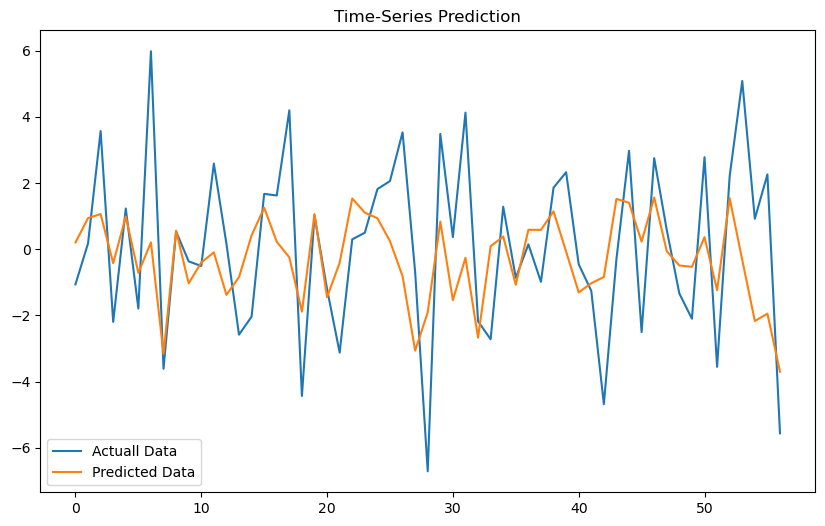

In [366]:
train_predict = lstm1(X_test_tensors_final)
data_predict = train_predict.data.numpy() 
dataY_plot = y_test_tensors.data.numpy()

plt.figure(figsize=(10,6)) 

plt.plot(dataY_plot, label='Actuall Data') 
plt.plot(data_predict, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [367]:
real_data = df026_dag['perdag_verbruik'][:-2][307:]
len(real_data)

57

In [368]:
len(data_predict)

57

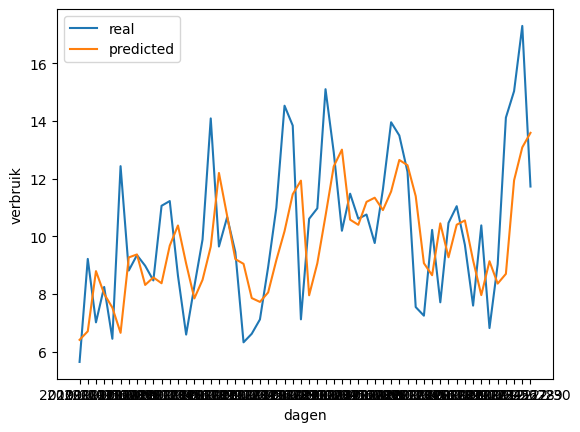

In [369]:
predicted = []
update = real_data[0]
for previous, pred in zip(real_data[:-1], data_predict[1:]):
    predicted.append(previous+pred)
plt.plot(real_data[1:], label = 'real')
plt.plot(predicted, label = 'predicted')
plt.ylabel('verbruik')
plt.xlabel('dagen')
plt.legend()
plt.show()

In [370]:
r2_score(real_data[1:], predicted)

0.19110075778265934

In [338]:
torch.save(lstm1, 'model.pt')

In [339]:
model = torch.load('topmodel.pt')
model.eval()

LSTM1(
  (lstm): LSTM(1, 35, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (fc1): Linear(in_features=35, out_features=128, bias=True)
  (relu): ReLU()
)

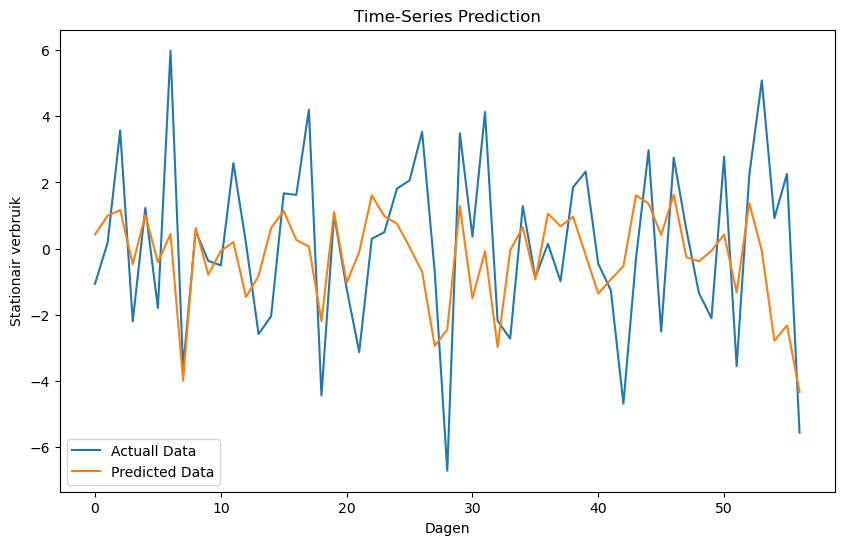

In [340]:
train_predict = model(X_test_tensors_final)
data_predict = train_predict.data.numpy() 
dataY_plot = y_test_tensors.data.numpy()

plt.figure(figsize=(10,6)) 

plt.plot(dataY_plot, label='Actuall Data') 
plt.plot(data_predict, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.xlabel('Dagen')
plt.ylabel('Stationair verbruik')
plt.legend()
plt.show() 

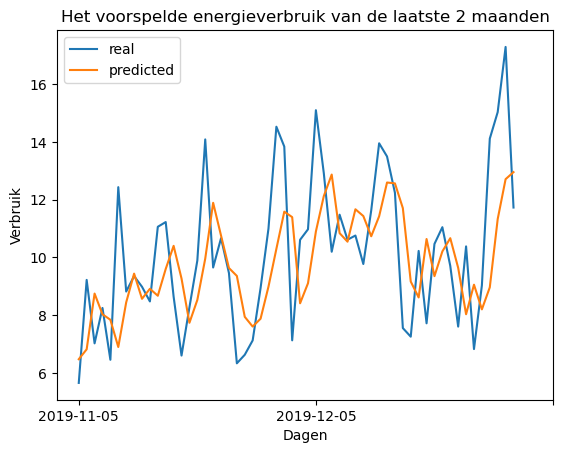

In [344]:
predicted = []
update = real_data[0]
for previous, pred in zip(real_data[:-1], data_predict[1:]):
# for previous, pred in zip(real_data, data_predict):
    predicted.append(previous+pred)
plt.plot(real_data[1:], label = 'real')
plt.plot(predicted, label = 'predicted')
plt.xticks([0, 30, 60])
plt.legend()
plt.title('Het voorspelde energieverbruik van de laatste 2 maanden')
plt.xlabel('Dagen')
plt.ylabel('Verbruik')
plt.show()

In [345]:
r2_score(real_data[1:], predicted) 

0.20358658097969207